# Git 分析 Notebook
统计每个 commit 中各个预定义技术栈文件的数量和代码量

### 从Data路径下加载多个分析结果

In [3]:
from notebook_utils import select_repo_and_run, set_cjk_font

set_cjk_font()

base_dir="../data"
repo_selector, run_selector = select_repo_and_run(base_dir)

✅ 已设置字体为：Arial Unicode MS


Dropdown(description='Repo:', layout=Layout(width='50%'), options=('git2base',), value='git2base')

Dropdown(description='Run:', layout=Layout(width='50%'), options=('snapshot_20250728_155908', 'snapshot_202507…

### 从选择路径下加载CSV

In [8]:
from typing import cast

from pandas import DataFrame
from notebook_utils import load_csv_results

selected_path, loaded_dfs = load_csv_results(repo_selector, run_selector, base_dir)

# 使用具体的 DataFrame
commit_files_df = cast(DataFrame, loaded_dfs.get("commit_files_df"))
diff_results_df = cast(DataFrame, loaded_dfs.get("diff_results_df"))
analysis_results_df = cast(DataFrame, loaded_dfs.get("analysis_results_df"))
commits_df = cast(DataFrame, loaded_dfs.get("commits_df"))

Selected path: ../data/git2base/snapshot_20250728_155908
✅ Loaded: commit_files.csv (27 rows)
❌ File not found: diff_results.csv
✅ Loaded: analysis_results.csv (16 rows)
✅ Loaded: commits.csv (1 rows)


### 合并数据

In [9]:
import pandas as pd

# 重命名 commits.csv 中的 hash 字段
commits_df = commits_df.rename(columns={"hash": "commit_hash"})

# 合并 commit_files 和 analysis_results（依据 commit_hash 和 path）
merged_df = pd.merge(commit_files_df, analysis_results_df, on=["commit_hash", "path"], how="left")

# 合并 commit 元数据
merged_df = pd.merge(merged_df, commits_df, on="commit_hash", how="left")
merged_df["analyzer_type"].unique()


array([nan, 'FileLineCount', 'FileCharCount'], dtype=object)

### 提取行数和字符数的记录

In [10]:
# 提取 line_count 和 char_count 两种分析类型的记录
line_df = merged_df[merged_df["analyzer_type"] == "FileLineCount"]
char_df = merged_df[merged_df["analyzer_type"] == "FileCharCount"]

### 统计每个技术栈代码的总数

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取 char_count 分析结果
char_df = merged_df[merged_df["analyzer_type"] == "FileCharCount"]

# 按 tech_stack 统计字符总数
char_summary = char_df.groupby("tech_stack")["count"].sum().reset_index(name="total_char_count")

# 按 tech_stack 统计文件数（唯一 path 数量）
file_count_summary = commit_files_df.groupby("tech_stack")["path"].nunique().reset_index(name="file_count")

# 合并两个统计结果
summary_df = pd.merge(char_summary, file_count_summary, on="tech_stack", how="left")

# 排序（可选）
summary_df = summary_df.sort_values("total_char_count", ascending=False)

# 过滤太小的比例（可选）
summary_df = summary_df[summary_df["total_char_count"] > 0]
summary_df

,tech_stack,total_char_count,file_count
1,Python,30641.0,6
0,PyTest,2508.0,1
2,Yaml,1762.0,1


### 绘制代码量分布图（按百分比，显示文件数量信息）

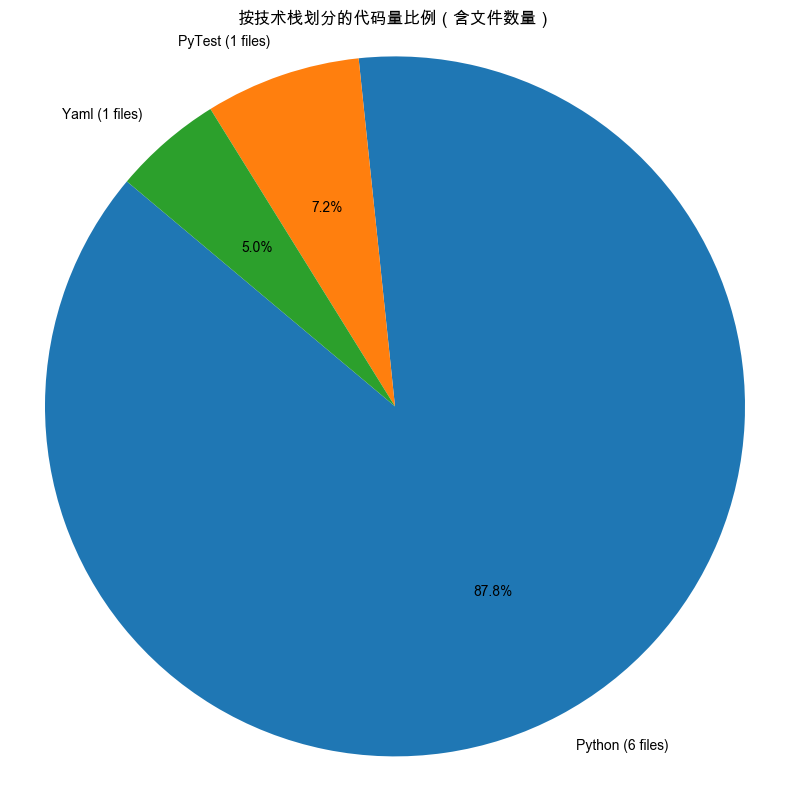

In [12]:
plt.figure(figsize=(8, 8))

# 扇形图内容为 char 数量，标签为 tech_stack，附带文件数量
labels = [
    f"{row['tech_stack']} ({row['file_count']} files)"
    for _, row in summary_df.iterrows()
]

plt.pie(
    summary_df["total_char_count"],
    labels=labels,
    autopct='%1.1f%%',
    startangle=140
)

plt.title("按技术栈划分的代码量比例（含文件数量）")
plt.axis("equal")  # 保证是圆形
plt.tight_layout()
plt.show()

### 保存结果为 CSV

In [13]:
summary_df.to_csv("output/filechar_dist_by_techstack.csv", index=False)
print("✅ 已保存分析结果至 output/filechar_dist_by_techstack.csv")


✅ 已保存分析结果至 output/filechar_dist_by_techstack.csv
